# 1. Import libraries

In [1]:
import os
import time
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

import lightgbm as lgb

warnings.filterwarnings('ignore')

# 2. Seeding random

In [2]:
np.random.seed(42)

# 3. Declaring DataExplorer class

In [3]:
class DataExplorer:
    """
    Reading dataset
    """
    def __init__(self, filedir, filename):
        self.data = pd.read_csv(os.path.join(filedir, filename))
        
    def grouper_quality(self, row):
        """
        Enlarging groups of target features
        """
        quality = row['quality']

        if quality < 5:
            return 3

        elif quality > 6:
            return 1

        else:
            return 2
        
    def generalization(self):
        """
        Greate enlarged groups of target features: third, second and first class wines
        """
        data = self.data.copy()
        data['gen_quality'] = self.data.apply(self.grouper_quality, axis=1)

        return data.drop('quality', axis=1)
    
    def binomizator(self):
        """
        Binominaizing target features
        """
        data = self.data.copy()
        data['bi_quality'] = self.data.quality.apply(lambda x: 1 if x >= 6 else 0)

        return data.drop('quality', axis=1)

    class Reporter():
        """
        Collecting perfomance data and bulids report
        """
        def __init__(self, data, target, features_dict, models, binomial=False):
            """
            Instances for Reporter
            """

            self.final_report = None
            self.best_estimator = []
            self.predictions = []
            self.data = data
            self.target = target
            self.models = models
            self.binomial = binomial
            self.score = f1_score
            self.scoring = 'f1_micro'
            self.random_state = 42
            self.features_dict = features_dict
            self.folds = 5

        def metrics_plot(self, model, model_title, features_valid, target_valid):
            """
            Displays the PR curve and ROC curve
            """

            probabilities_valid = model.predict_proba(features_valid)
            precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
            fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
            fig.subplots_adjust(hspace=0.4, wspace=0.4)

            sns.lineplot(recall, precision, drawstyle='steps-post', ax=ax[0])
            ax[0].set_xlabel('Recall')
            ax[0].set_ylabel('Precision')
            ax[0].set_ylim([0.0, 1.05])
            ax[0].set_xlim([0.0, 1.0])
            ax[0].set_title('Precision-Recall Curve ' + model_title)

            sns.lineplot(fpr, tpr, ax=ax[1])
            ax[1].plot([0, 1], [0, 1], linestyle='--')
            ax[1].set_xlim(0, 1)
            ax[1].set_ylim(0, 1)
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')
            ax[1].set_title('ROC-curve ' + model_title)

        def auc_roc(self, model, features_valid, target_valid):
            """
            Calculating ROC-AUC
            """

            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

            return auc_roc

        def grid_search(self, model, param_grid, x_features, y_features):
            """
            GridSearchCV
            """
            kfold = KFold(n_splits=self.folds, shuffle=True,
                          random_state=self.random_state)
            grid_model = GridSearchCV(model, param_grid=param_grid,
                                      scoring=self.scoring, cv=kfold,
                                      verbose=1, n_jobs=-1, )
            grid_model.fit(x_features, y_features)
            best_estimator = grid_model.best_estimator_
            return best_estimator

        def data_spliter(self, features):
            """
            Splitting data into training and test in a ratio of 60:40
            """
            x_train, x_test, y_train, y_test = train_test_split(self.data[features], 
                                                                self.data[self.target], 
                                                                train_size=0.6, 
                                                                stratify=self.data[self.target],
                                                                random_state=self.random_state)

            return x_train, y_train, x_test, y_test

        def reporter(self):

            started = time.time()
            report = []
            estimators = []
            predictions = []
            score_name = str(self.score).split(' ')[1]
            models = self.models

            for key in self.features_dict:

                features = self.features_dict[key]

                print('Features set - ', key)

                x_train, y_train, x_test, y_test = self.data_spliter(features)
                
                x_train = np.log(x_train, where=x_train>0)
                x_test = np.log(x_test, where=x_test>0)

                scaler = StandardScaler()

                x_train = scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)

                print('Dataset was splitted into training and test in a ratio of 60:40 and scaled using StandardScaler. \n')
                print('Shapes: \n')
                print('- train ', x_train.shape, y_train.shape)
                print('- test ', x_test.shape, y_test.shape)
                print('\n')

                print('Report: ')

                for model in models:
                    started_local = time.time()
                    print('\n', model[0], '\n')
                    grid_search = self.grid_search(model[1], model[2], x_train, y_train)
                    print(grid_search)
                    ended_local = time.time()
                    predicted_test = np.ravel(grid_search.predict(x_test))
                    test_score = self.score(y_test, predicted_test, average='micro')

                    report.append((model[0], test_score, ended_local-started_local, key))
                    estimators.append((model[0], grid_search))
                    predictions.append((model[0], predicted_test))
                    if self.binomial == True:
                        self.metrics_plot(grid_search, model[0], x_test, y_test)
                    print('\n', 'Classification report for ' + model[0], '\n\n', classification_report(y_test, predicted_test))

                print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
            self.final_report = pd.DataFrame(report, columns=['model', score_name + '_test', 'seconds_to_fit', 'features_key'])
            self.best_estimator = pd.DataFrame(estimators, columns=['model', 'grid_params'])
            self.predictions = pd.DataFrame(predictions, columns=['model', 'test_predictions'])
            ended = time.time()
            print('Cross-validation training and parameter search completed in {} sec.'.format(round(ended-started, 2)))

In [4]:
explorer = DataExplorer('/kaggle/input/red-wine-quality-cortez-et-al-2009/', 'winequality-red.csv')

# 4. Defining features bunch

In [5]:
dict_of_features_combinations = {'all_features': ['fixed acidity', 'volatile acidity', 'citric acid', 
                                                   'residual sugar', 'chlorides', 'free sulfur dioxide', 
                                                   'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                                                   'alcohol'],
                                 
                                 'most_important': ['volatile acidity', 'residual sugar', 'sulphates', 'alcohol']}

# 5. Preparing models and parameters for tuning

In [6]:
models_list = []

#### - LGBMClassifier

In [7]:
lg = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

param_grid = {'boosting_type': ['gbdt'],
              'num_leaves': [10, 20, 30],
              'num_iterations': [600],
              'learning_rate': [0.01, 0.0001],
              'max_depth': [10, 30, 100]}

models_list.append(('LGBMClassifier', lg, param_grid))

# 6. Report for multiple classifications

In [8]:
explorer.data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [9]:
multi_report = explorer.Reporter(explorer.data, 'quality', dict_of_features_combinations, models_list)

In [10]:
multi_report.reporter()

Features set -  all_features
Dataset was splitted into training and test in a ratio of 60:40 and scaled using StandardScaler. 

Shapes: 

- train  (959, 11) (959,)
- test  (640, 11) (640,)


Report: 

 LGBMClassifier 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=30, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=20, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.20      0.10      0.13        21
           5       0.70      0.70      0.70       273
           6       0.61      0.63      0.62       255
           7       0.49      0.49      0.49        80
           8       0.23      0.43      0.30         7

    accuracy                           0.62       640
   macro avg       0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   58.4s finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=30, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=30, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.13      0.14      0.14        21
           5       0.68      0.66      0.67       273
           6       0.57      0.52      0.54       255
           7       0.44      0.55      0.49        80
           8       0.23      0.43      0.30         7

    accuracy                           0.57       640
   macro avg       0.

In [11]:
multi_report.final_report

,model,f1_score_test,seconds_to_fit,features_key
0,LGBMClassifier,0.617188,99.713907,all_features
1,LGBMClassifier,0.565625,60.569317,most_important


# 7. Report for enlarged groups classifications: three classes of wine (1 - best, 3 - worst)

In [12]:
df_three_classed = explorer.generalization()

In [13]:
df_three_classed

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,gen_quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,2
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,2
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,2
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,2
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,2
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,2


In [14]:
gen_report = explorer.Reporter(df_three_classed, 'gen_quality', dict_of_features_combinations, models_list)

In [15]:
gen_report.reporter()

Features set -  all_features
Dataset was splitted into training and test in a ratio of 60:40 and scaled using StandardScaler. 

Shapes: 

- train  (959, 11) (959,)
- test  (640, 11) (640,)


Report: 

 LGBMClassifier 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   44.8s finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=30, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=30, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           1       0.60      0.70      0.65        87
           2       0.91      0.90      0.91       528
           3       0.29      0.20      0.24        25

    accuracy                           0.85       640
   macro avg       0.60      0.60      0.60       640
weighted avg       0.85      0.85      0.85       640

--------------------------------------------------------------------
-----

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.0s finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=30, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=30, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           1       0.49      0.72      0.59        87
           2       0.91      0.81      0.86       528
           3       0.20      0.32      0.24        25

    accuracy                           0.78       640
   macro avg       0.53      0.62      0.56       640
weighted avg       0.83      0.78      0.80       640

--------------------------------------------------------------------
-----

In [16]:
gen_report.final_report

,model,f1_score_test,seconds_to_fit,features_key
0,LGBMClassifier,0.846875,46.222466,all_features
1,LGBMClassifier,0.782813,31.021212,most_important


# 8. Report for binomial classifications

In [17]:
df_binomial = explorer.binomizator()

In [18]:
bi_report = explorer.Reporter(df_binomial, 'bi_quality', dict_of_features_combinations, models_list, binomial=True)

Features set -  all_features
Dataset was splitted into training and test in a ratio of 60:40 and scaled using StandardScaler. 

Shapes: 

- train  (959, 11) (959,)
- test  (640, 11) (640,)


Report: 

 LGBMClassifier 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=10, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           0       0.72      0.78      0.75       298
           1       0.79      0.74      0.77       342

    accuracy                           0.76       640
   macro avg       0.76      0.76      0.76       640
weighted avg       0.76      0.76      0.76       640

--------------------------------------------------------------------
-----------------------------------------------------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.9s finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=30, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=600, num_leaves=30, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report for LGBMClassifier 

               precision    recall  f1-score   support

           0       0.72      0.76      0.74       298
           1       0.78      0.74      0.76       342

    accuracy                           0.75       640
   macro avg       0.75      0.75      0.75       640
weighted avg       0.75      0.75      0.75       640

--------------------------------------------------------------------
-----------------------------------------------------------

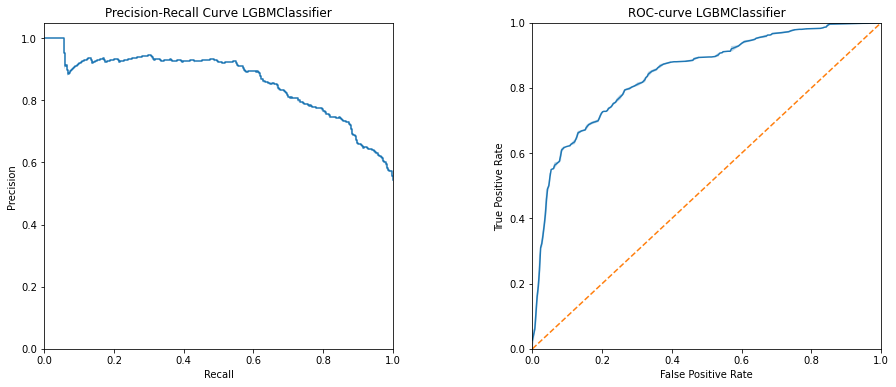

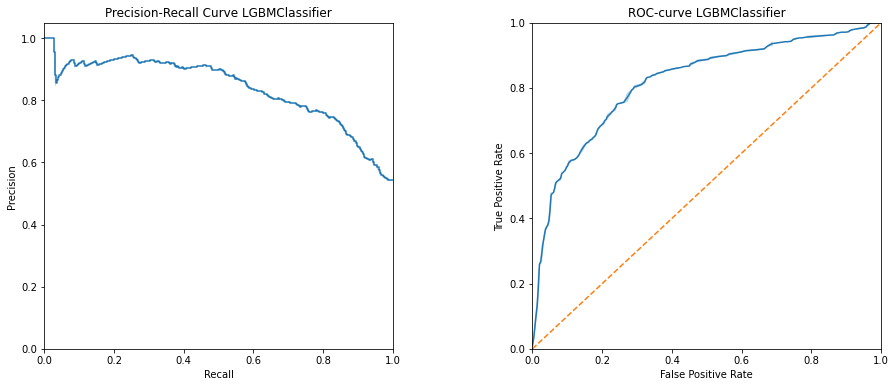

In [19]:
bi_report.reporter()

In [20]:
bi_report.final_report

,model,f1_score_test,seconds_to_fit,features_key
0,LGBMClassifier,0.757812,15.233103,all_features
1,LGBMClassifier,0.750000,10.271824,most_important
